In [51]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style

style.use('bmh')
style.use('dark_background')

## Loading tha manipulation of data

In [52]:
data = np.asanyarray(pd.read_csv('./LabelledTheta.csv', delimiter=',', header=None))

NUM_CHANNELS = 14
ACTUAL_VALUES = 38
CONST_VALUES = 64 - 38
NUM_THETA_VALUES_PER_CHANNEL = ACTUAL_VALUES + CONST_VALUES
NUM_QUBITS = 6

data

array([['Ankur_sir_6', 0.5116529233737879, 2.661255444814941, ..., 0.0,
        0.0, 'Like'],
       ['Sandeep_32', -0.9532752329297408, -4.419225848654918, ..., 0.0,
        0.0, 'Disike'],
       ['mahendra_28', -0.4930886480644289, -1.5454615508228926, ...,
        0.0, 0.0, 'Like'],
       ...,
       ['mahendra_5', -1.9427615337039161, -12.76711513386849, ..., 0.0,
        0.0, 'Like'],
       ['taufiq_10', -0.34627782376502125, -1.75569285697388, ..., 0.0,
        0.0, 'Disike'],
       ['Vijay_32', 0.42956267802355796, 2.191135723676666, ..., 0.0,
        0.0, 'Disike']], dtype=object)

In [53]:
def normalize(X_data):
    for i in range(len(X_data)):
        mu = X_data[i].mean()
        sigma = X_data[i].std()

        X_data[i] = (X_data[i] - mu) / sigma

        for j in range(NUM_CHANNELS):
              for k in range(NUM_THETA_VALUES_PER_CHANNEL):
                idx = j * NUM_THETA_VALUES_PER_CHANNEL + k
                if X_data[i][idx] > 2:
                    X_data[i][idx] = 2
                elif X_data[i][idx] < -2:
                    X_data[i][idx] = -2

                if k >= ACTUAL_VALUES:
                    X_data[i][idx] = -2.5

        X_data[i] = ((X_data[i] / 5) + 0.5)
            
    return X_data

In [54]:
# TODO: change the function for different encoding
def get_angles(X_data):
    X_angles = []
    for i in range(len(X_data)):
        X_i = []
        for j in range(NUM_CHANNELS):
            for q in range(NUM_QUBITS):
                probab_sum = 0.0
                for k in range(NUM_THETA_VALUES_PER_CHANNEL):
                    idx = j * NUM_THETA_VALUES_PER_CHANNEL + k

                    if k & (0x1 << q):
                        probab_sum += X_data[i][idx]

                X_i.append(2 * np.arcsin(np.sqrt(probab_sum)))

        X_angles.append(np.array(X_i))

    return X_angles

In [55]:
def convert_to_probability(X_data):
    X_data_probab = []
    for i in range(len(X_data)):
        X_i = []
        for j in range(NUM_CHANNELS):
            channel_j = []
            for k in range(NUM_THETA_VALUES_PER_CHANNEL):
                idx = j * NUM_THETA_VALUES_PER_CHANNEL + k
                channel_j.append(X_data[i][idx])

            total_ch_j = sum(channel_j)
            channel_j = np.array(channel_j) / total_ch_j

            for k in range(NUM_THETA_VALUES_PER_CHANNEL):
                X_i.append(channel_j[k])
    
        X_data_probab.append(np.array(X_i))

    return X_data_probab

In [56]:
def arrange_channelwise(X_data):
    X_data_channelwise = []
    for i in range(NUM_CHANNELS):
        X_i = []
        for j in range(len(X_data)):
            X_j = []
            for k in range(NUM_QUBITS):
                idx = i * NUM_QUBITS + k
                X_j.append(X_data[j][idx])
                
            X_i.append(np.array(X_j))
            
        X_data_channelwise.append(np.array(X_i))
        
    return X_data_channelwise

In [60]:
X = []
Y = []
for i in range(len(data)):
    X.append(data[i][1:-1])
    Y.append(data[i][-1])
    
index = np.random.permutation(range(len(X)))
print(index, len(index))
    
X_norm = normalize(X)
X_probab = convert_to_probability(X_norm)
X_ang = np.array(get_angles(X_probab))[index[:100]]

[286   6 566 ...  69 821 207] 1045


In [61]:
print(type(X_ang), type(X_ang[0]))
print(len(X_ang), len(X_ang[0]))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
100 84


In [62]:
X_chwise = arrange_channelwise(X_ang)
Y_bin = np.array([1 if y == 'Like' else -1 for y in Y])

print(len(X_chwise), len(X_chwise[0]), len(X_chwise[0][0]))

14 100 6


In [63]:
train_idxs = int(len(X_ang)*0.7)+1
test_idxs = int(train_idxs + len(X_ang)*0.2)

X_train = X_ang[:train_idxs]
Y_train = Y_bin[:train_idxs]

X_test = X_ang[train_idxs:test_idxs]
Y_test = Y_bin[train_idxs:test_idxs]

X_val = X_ang[test_idxs:]
Y_val = Y_bin[test_idxs:]

In [64]:
X_train_chwise = arrange_channelwise(X_train)
X_test_chwise = arrange_channelwise(X_test)
X_val_chwise = arrange_channelwise(X_val)

print(len(X_train_chwise), len(X_train_chwise[0]))
print(len(X_test_chwise), len(X_test_chwise[0]))
print(len(X_val_chwise), len(X_val_chwise[0]))

14 71
14 20
14 9


## Creating the quantum network

In [65]:
def layer(W, num_wires):
    for i in range(num_wires):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
        
    for j in range(num_wires):
        if j != num_wires-1:
            qml.CNOT(wires=[j, j+1])
        else:
            qml.CNOT(wires=[j, 0])

In [66]:
def statePreparation(a):
    for i in range(len(a)):
        qml.RY(a[i], wires=i)
        qml.Hadamard(wires=i)
        if i == 5:
            qml.CZ(wires=[i, 0])
        else:
            qml.CZ(wires=[i, i+1])

In [67]:
dev = qml.device('default.qubit', wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit(weights, angles):
    statePreparation(angles)
    
    for W in weights:
        layer(W, NUM_QUBITS)
        
    return qml.expval(qml.PauliZ(0))

## Some helper functions

In [68]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss += ((l - p)**2)
        
    loss /= len(labels)
    return loss

################################################################################################
def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss += 1
            
    loss /= len(labels)
    return loss

## Building the variational classifier

In [69]:
def variational_classifier(var, ang=None):
    weights = var[0]
    bias = var[1]
    return circuit(weights, ang) + bias

In [70]:
def cost(weights, features, labels):
    predictions = [variational_classifier(weights, f) for f in features]
    return square_loss(labels, predictions)

## Fitting the model

In [71]:
NUM_LAYERS = 10
bias = 0.03
var_init = (0.01 * np.random.randn(NUM_LAYERS, NUM_QUBITS, 3), bias)

In [72]:
optimizer = AdamOptimizer(0.9)
Batch_Size = 2

def fit_model(x, y, init_weights, batch_size, epochs, opt, validation_data, cost_calc_data):
    var = init_weights
    history = {'cost':[], 'acc_train':[], 'acc_val':[], 'iter_history':[]}
    
    for e in range(epochs):
        history['iter_history'].append({'cost':[], 'acc_train':[], 'acc_val':[]})
        print("EPOCH: ", e+1)
        for it in range(10):
            # Update the weights by one optimizer step
            batch_index = np.random.randint(0, train_idxs, (batch_size,))
            X_train_batch = x[batch_index]
            Y_train_batch = y[batch_index]
            var = opt.step(lambda v: cost(v, X_train_batch, Y_train_batch), var)

            # Compute predictions on train and validation set
            print('Train iter: ', it+1, end='\t')
            predictions_train = [np.sign(variational_classifier(var, f)) for f in x]
            print('Test iter: ', it+1, end='\t')
            predictions_val = [np.sign(variational_classifier(var, f)) for f in validation_data[0]]
            
            
            # Compute accuracy on train and validation set
            history['iter_history'][e]['acc_train'].append(accuracy(y, predictions_train))
            history['iter_history'][e]['acc_val'].append(accuracy(validation_data[1], predictions_val))
            history['iter_history'][e]['cost'].append(cost(var, cost_calc_data[0], cost_calc_data[1]))
            
            # Print iter-wise value
            print(
                "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
                "".format(it + 1, history['iter_history'][e]['cost'][-1], history['iter_history'][e]['acc_train'][-1],
                history['iter_history'][e]['acc_val'][-1])
            )
        
        # Store parameters for later use
        history['acc_train'].append(sum(history['iter_history'][e]['acc_train'])/10)
        history['acc_val'].append(sum(history['iter_history'][e]['acc_val'])/10)
        history['cost'].append(sum(history['iter_history'][e]['cost'])/10)

        print(
            "\n\nEpoch: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
            "".format(e + 1, history['cost'][-1], history['acc_train'][-1], history['acc_val'][-1])
        )
        
        return history

In [73]:
ch1_history = fit_model(x=X_train_chwise[0],
                         y=Y_train,
                         init_weights=var_init,
                         batch_size=Batch_Size,
                         epochs=3,
                         opt=optimizer,
                         validation_data=(X_test_chwise[0], Y_test),
                         cost_calc_data=(X_chwise[0], Y_bin))

EPOCH:  1
Train iter:  1	Test iter:  1	Iter:     1 | Cost: 0.1753634 | Acc train: 0.5352113 | Acc validation: 0.5500000 
Train iter:  2	Test iter:  2	Iter:     2 | Cost: 0.3210243 | Acc train: 0.5352113 | Acc validation: 0.5500000 
Train iter:  3	Test iter:  3	Iter:     3 | Cost: 0.3482852 | Acc train: 0.5352113 | Acc validation: 0.5500000 
Train iter:  4	Test iter:  4	Iter:     4 | Cost: 0.4027804 | Acc train: 0.5352113 | Acc validation: 0.5500000 
Train iter:  5	Test iter:  5	Iter:     5 | Cost: 0.4379331 | Acc train: 0.5352113 | Acc validation: 0.5500000 
Train iter:  6	Test iter:  6	Iter:     6 | Cost: 0.4628547 | Acc train: 0.5352113 | Acc validation: 0.5500000 
Train iter:  7	Test iter:  7	Iter:     7 | Cost: 0.4567560 | Acc train: 0.5352113 | Acc validation: 0.5500000 
Train iter:  8	Test iter:  8	Iter:     8 | Cost: 0.4541911 | Acc train: 0.5352113 | Acc validation: 0.5500000 
Train iter:  9	Test iter:  9	Iter:     9 | Cost: 0.2552278 | Acc train: 0.5352113 | Acc validation: 0.

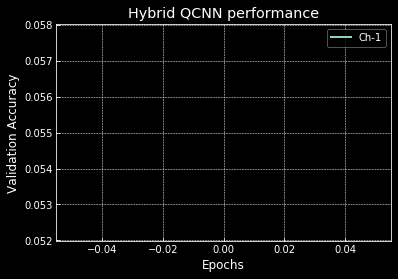

In [46]:
plt.plot(np.array(ch1_history['acc_val']), label='Ch-1')
plt.title('Hybrid QCNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()